In [232]:
import numpy as np
import pymorphy2
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from collections import Counter

from catboost import CatBoostRegressor

from vgram import VGram

In [233]:
morph = pymorphy2.MorphAnalyzer()

def to_lemmas(sent):
    return " ".join(morph.parse(w)[0].normal_form for w in sent.split())

def read_test():
    path = "dataset_40757_1.txt"
    with open(path) as f:
        X = list(map(lambda x: to_lemmas(x.strip()), f.read().strip().split('\n')))
    X = np.array(X)
    return X

def read_data():
    with open("scores_train.txt") as f:
        y = list(map(lambda x: float(x.strip()), f.read().strip().split('\n')))
    with open("texts_train.txt") as f:
        X = list(map(lambda x: to_lemmas(x.strip()), f.read().strip().split('\n')))
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all, y_all = read_data()
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, train_size=0.7)

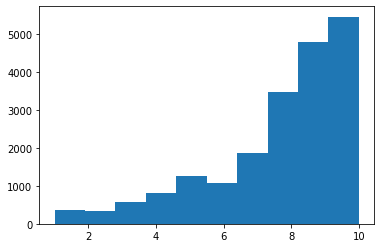

In [234]:
plt.hist(y_all)
plt.show()

In [288]:
cnt = Counter(y_tr)
tr_weights = [cnt[y_tr[i]] for i in range(len(y_tr))]

In [296]:
print(y_tr[:20])
print(tr_weights[:20])

[ 7.  3.  9. 10. 10.  4. 10.  9.  7.  9.  8.  7.  1.  9.  5.  9.  9. 10.
 10. 10.]
[1299, 404, 3349, 3815, 3815, 559, 3815, 3349, 1299, 3349, 2438, 1299, 244, 3349, 872, 3349, 3349, 3815, 3815, 3815]


In [280]:
# fit_vgram = VGram(5000, 10).fit(X_all)
fit_vgram_15k = VGram(15000, 15).fit(X_all)

In [291]:
def vgram_sgd():
#     1.7594020482846366
#     2.0008748086774446
    vgram = Pipeline([
            ("vgb", fit_vgram_15k),
            ("vect", CountVectorizer(ngram_range=(1,2)))
    ])
    pipeline = Pipeline([
            ("features", FeatureUnion([("vgb", vgram), ("words", CountVectorizer())])),
            ('tfidf', TfidfTransformer(sublinear_tf=True)),
            ("sgd", SGDRegressor(loss='squared_loss', penalty='elasticnet', l1_ratio=0.1, eta0=0.3, alpha=1e-4, max_iter=500))
    ])
    return pipeline

# ------------

def sgd_reg():
    return Pipeline([("vect", CountVectorizer()),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDRegressor(loss='squared_loss', penalty='elasticnet', l1_ratio=0.2, eta0=0.3, alpha=1e-4, max_iter=500))
                    ])

def bigrams_sgd():
    # 1.7871547437491544
    # 1.97087121175721
    return Pipeline([("vect", CountVectorizer(ngram_range=(1,2))),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDRegressor(loss='squared_loss', penalty='elasticnet', 
                                         l1_ratio=0.3, eta0=0.3, alpha=1e-4, max_iter=500))
                    ])

def sgd_class():
#     0.21061135500523911
#     2.180175833887411
    return Pipeline([("vect", CountVectorizer(ngram_range=(1,1))),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0., eta0=0.1,
                                          alpha=1e-4, max_iter=300))
                    ])

def nb_class():
#     2.363517354646309
#     2.521738818090935
    return Pipeline([
            ("vect", CountVectorizer()),
#             ('tfidf', TfidfTransformer()),
            ("nb", MultinomialNB())
    ])


trans = Pipeline([("vect", CountVectorizer(ngram_range=(1,2))),
                ("tfidf", TfidfTransformer(sublinear_tf=True))])

data_tr = trans.fit(X_tr).transform(X_tr)
model = SGDRegressor(loss='squared_loss', penalty='elasticnet', 
                     l1_ratio=0.3, eta0=0.3, alpha=1e-4, max_iter=500)

# model = sgd_reg()
# model = bigrams_sgd()
# model = sgd_class()
# model = nb_class()
# model = vgram_sgd()

# model = VotingRegressor([
#     ("sgd_reg", sgd_reg()),
#     ("bigrams_sgd", bigrams_sgd()),
#     ("sgd_class", sgd_class())],
#     weights=[1, 2, 1])
# model = VotingRegressor([("bigrams_sgd " + str(i), bigrams_sgd()) for i in range(10)])

model.fit(X_tr, y_tr, sample_weight=tr_weights)
y_pr = model.predict(X_te)
y_pr = np.clip(y_pr, a_max=10, a_min=0)
y_pr = np.array(y_pr, dtype=np.int32)
plt.hist(y_pred)
print(mean_squared_error(model.predict(X_tr), y_tr) ** 0.5)
print(mean_squared_error(y_pr, y_te) ** 0.5)

ValueError: could not convert string to float: 'читать 10 год назад - тогда книга показаться очень интересный'

(array([2.000e+00, 1.000e+00, 4.000e+00, 3.400e+01, 1.620e+02, 7.980e+02,
        2.251e+03, 2.313e+03, 4.140e+02, 2.100e+01]),
 array([-0.90084062,  0.38370926,  1.66825915,  2.95280903,  4.23735892,
         5.5219088 ,  6.80645869,  8.09100858,  9.37555846, 10.66010835,
        11.94465823]),
 <a list of 10 Patch objects>)

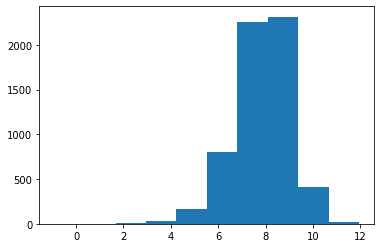

In [261]:
model = VotingRegressor([
    ("sgd_reg", sgd_reg()),
    ("bigrams_sgd", bigrams_sgd()),
    ("sgd_class", sgd_class())],
    weights=[1, 2, 1])
model = bigrams_sgd()
model.fit(X_all, y_all)

y_pr = model.predict(X_te)
plt.hist(y_pr)

In [262]:
X_test = read_test()
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, a_max=10, a_min=0)
y_pred = np.array(y_pred, dtype=np.int32)
with open("out.txt", 'w') as f:
    f.write("\n".join(map(lambda x: str(int(x)), y_pred)))

In [149]:
# print(len(y_all))
# sorted(y_all)[15000]
Counter(y_all)

Counter({6.0: 1061,
         7.0: 1872,
         10.0: 5450,
         5.0: 1269,
         9.0: 4787,
         8.0: 3469,
         3.0: 580,
         4.0: 806,
         1.0: 358,
         2.0: 348})

In [ ]:
X_good = X_tr[]

In [282]:
class MyEst:
    def __init__(self, split=8, ngram_range=(1,1), iters=500):
        self.split = split
        self.classifier = Pipeline([("vect", CountVectorizer(ngram_range=ngram_range)),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDClassifier(loss='modified_huber', penalty='elasticnet', l1_ratio=0.3, eta0=0.3, alpha=1e-4, max_iter=iters))
                    ])
        self.regressor_bad = Pipeline([("vect", CountVectorizer(ngram_range=ngram_range)),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDRegressor(loss='squared_loss', penalty='elasticnet', l1_ratio=0.3, eta0=0.3, alpha=1e-4, max_iter=iters))
                    ])

        self.regressor_good = Pipeline([("vect", CountVectorizer(ngram_range=ngram_range)),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDRegressor(loss='squared_loss', penalty='elasticnet', l1_ratio=0.3, eta0=0.3, alpha=1e-4, max_iter=iters))
                    ])
        
        self.classifier_good = Pipeline([("vect", CountVectorizer(ngram_range=ngram_range)),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDClassifier(loss='modified_huber', penalty='elasticnet', l1_ratio=0.3, eta0=0.3, alpha=1e-4, max_iter=iters))
                    ])
        
    def fit(self, X_tr, y_tr):
        split = self.split
        y_tr_class = y_tr >= split
        X_tr_good = X_tr[y_tr >= split]
        y_tr_good = y_tr[y_tr >= split]
        X_tr_bad = X_tr[y_tr < split]
        y_tr_bad = y_tr[y_tr < split]
        
        for i, (good_ind, bad_ind) in enumerate(zip(range(split, 11), range(5, 10 - split - 1, -1))):
            num = len(y_tr[y_tr == bad_ind])
            X_good_add = np.random.choice(X_tr[y_tr == good_ind], num)
            X_tr_bad = np.append(X_tr_bad, X_good_add)
            y_tr_bad = np.append(y_tr_bad, np.array([good_ind] * num))
        
        cnt = Counter(y_tr_bad)
        plt.bar(list(cnt), list(cnt.values()))
        plt.show()
            
        self.classifier.fit(X_tr, y_tr_class)
        self.regressor_bad.fit(X_tr_bad, y_tr_bad)
        self.regressor_good.fit(X_tr_good, y_tr_good)
        self.classifier_good.fit(X_tr_good, y_tr_good)
        
    def predict(self, X_te):
        goodnes_prob = self.classifier.predict_proba(X_te)

        y_pr_bad = self.regressor_bad.predict(X_te)
        y_pr_good = self.regressor_good.predict(X_te)
        y_pr = goodnes_prob[:, 0] * y_pr_bad + goodnes_prob[:, 1] * y_pr_good

        class_pred = self.classifier.predict(X_te)
        y_pr = class_pred * self.classifier_good.predict(X_te) + (1 - class_pred) * self.regressor_bad.predict(X_te)
        
        y_pr[class_pred == 1] = self.classifier_good.predict(X_te)[class_pred == 1]

        y_pr = np.clip(y_pr, a_max=10, a_min=0)
        y_pr = np.array(y_pr, dtype=np.int32)
        return y_pr

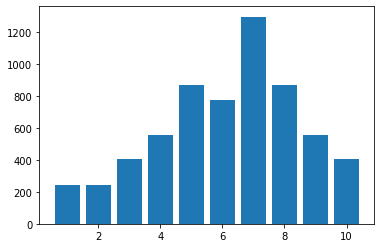

1.127861440324754
1.9745463614038878

1.5603518371670178
2.658578186678651


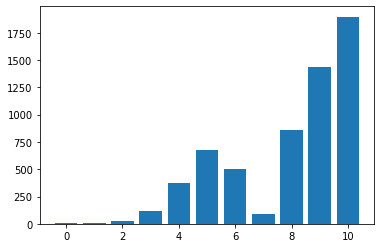

In [283]:
split=8
model = MyEst(split=split, ngram_range=(1,2), iters=500)
model.fit(X_tr, y_tr)
print(mean_squared_error(model.predict(X_tr), y_tr) ** 0.5)
y_pr = model.predict(X_te)
print(mean_squared_error(y_pr, y_te) ** 0.5)
print()
print(mean_squared_error(y_pr[y_te >= split], y_te[y_te >= split]) ** 0.5)
print(mean_squared_error(y_pr[y_te < split], y_te[y_te < split]) ** 0.5)
# print(np.mean(model.predict(X_te) == np.array(y_te >= 8, dtype=np.bool8))) Score: 0.779
cnt = Counter(y_pr)
plt.bar(list(cnt), list(cnt.values()))
plt.show()

[9, 10, 5, 8, 6, 4, 7, 3, 2] [1579, 1977, 482, 1016, 682, 99, 157, 5, 3]


<BarContainer object of 9 artists>

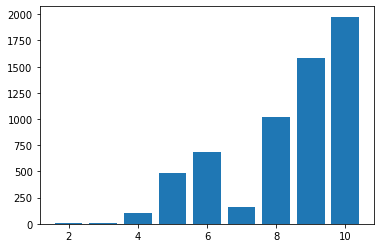

In [210]:
# y_pr = model.predict(X_te)
cnt = Counter(y_pr)
plt.bar(list(cnt), list(cnt.values()))

In [169]:
np.mean(y_tr[y_tr < 8])

5.031749605944607

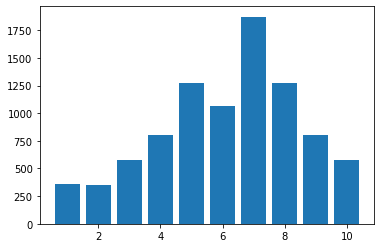

/Users/aleksandr.khvorov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [227]:
model = MyEst(split=split, ngram_range=(1,2), iters=500)
model.fit(X_all, y_all)
X_test = read_test()
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, a_max=10, a_min=0)
y_pred = np.array(y_pred, dtype=np.int32)
with open("out.txt", 'w') as f:
    f.write("\n".join(map(lambda x: str(int(x)), y_pred)))